# Simulation de l’évolution d’un réseau social et de la propagation de l’information au sein de ce réseau 







⚠️ Plus tard dans le projet, on utilisera le module community. Pour cela, il faut installer python-louvain : pip install python-louvain


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random as rd
import copy
import numpy as np
from math import *
import matplotlib.animation as animation
import time
import cProfile
import community as com
import matplotlib.cm as cm

## 1 - Réseau de type Facebook

In [ ]:
## Initialisation du modèle 
Nombre_internautes0 = 30
Init_amitiés0 = Nombre_internautes0 ## Nombre d'amitiés au sein du graphe de départ

Internautes0 = [ k for k in range(Nombre_internautes0) ] ## On associe un nombre à chaque internaute

Nombre_facteurs0 = 100 ## On crée des facteurs définissant les internautes
Scores0 = [ rd.randrange(100) for k in range(Nombre_facteurs0) ] ## On associe un score d'importance à chaque facteur 
Facteurs0 = [ rd.sample( [k for k in range(Nombre_facteurs0) ] , rd.randrange(Nombre_facteurs0+1) ) for l in range(Nombre_internautes0) ] ## On associe à chaque internaute certains facteurs

In [ ]:
def facteurs_communs0(i,j): ## Calcul des facteurs communs aux internautes i et j
    return list(set(Facteurs0[i]) & set(Facteurs0[j]))

def facteurs_communs_triple(i,j,m): ## Calcul des facteurs communs aux internautes i, j et m
    return list(set(Facteurs0[i]) & set(Facteurs0[j]) & set(Facteurs0[m]))


In [ ]:
def valeur0(i,j): ## Calcul de la valeur d'amitié entre deux internautes à partir de l'importance de leurs facteurs communs
    score = 0
    for k in facteurs_communs0(i,j):
        score += Scores0[k]
    return score


In [ ]:
def sans_doublon(l1): ## Fonction supprimant les doublons d'une liste l1
    L = []
    for k in l1:
        if k not in L:
            L.append(k)
    return L


Nous allons effectuer un **test unitaire** sur la fonction sans doublon


In [ ]:
import unittest

class TestDoublons(unittest.TestCase):

    def test_sans_doublon_liste_vide(self): #cas d'une liste vide
        l = sans_doublon([])
        self.assertEqual(l, [])

    def test_sans_doublon_liste_un_elem(self): #cas d'une liste ne contenant qu'un seul élément
        l = sans_doublon([8])
        self.assertEqual(l, [8])

    def test_sans_doublon_liste_deux_elem(self): #cas d'une liste contenant deux éléments différents
        l = sans_doublon([8,14])
        self.assertEqual(l, [8,14])
        
    def test_sans_doublon_liste_deux_elem2(self): #cas d'une liste contenant deux mêmes éléments 
        l = sans_doublon([8,8])
        self.assertEqual(l, [8])
        
    def test_sans_doublon_liste_plus_elem(self): ##cas d'une liste contenant plusieurs éléments
        l = sans_doublon([8,14,4,4,14])
        self.assertEqual(l, [8,14,4])

if __name__ == '__main__':
    unittest.main()

In [ ]:
def soustraction(l1,l2): ## Fonction enlevant les éléments de la liste l2 présent dans la liste l1
    return [ k for k in l1 if k not in l2]


In [ ]:
Valeurs0 = [ [ valeur0(i,j) for i in range(Nombre_internautes0) ] for j in range(Nombre_internautes0) ] ## On calcule la valeur de chaque amitié

Amitiés0 = sans_doublon( rd.sample( [ (i,j) for i in range(Nombre_internautes0) for j in range(i+1,Nombre_internautes0) if  facteurs_communs0(i,j) != []  ] , Init_amitiés0 ) ) ## On crée les amitiés du graphe de départ 
Aremplir = soustraction( [ (i,j) for i in range(Nombre_internautes0) for j in range( i+1 , Nombre_internautes0) ] , Amitiés0  ) ## On regarde les couples non-amis qui peuvent encore le devenir

G0 = [ Internautes0 , Amitiés0 , Aremplir ] ## On crée le graphe de départ que l'on fera évoluer

In [ ]:
def amis_communs(u,v,G): ## On recherche les amis en communs de deux internautes u et v
    L = []
    for w in range(Nombre_internautes0):
        if (min(w,u),max(w,u)) in G[1] and (min(w,v),max(w,v)) in G[1] :
            L.append(w)
    return L

In [ ]:
def passage0(D0,seuil,p): ## Passage à l'étape suivante en regardant chaque couple pouvant devenir une amitié
    G = D0[-1]
    D = []
    G0 = copy.deepcopy(G)
    for (u,v) in G[2]:
        L = amis_communs(u,v,G)
        if L != []:
            m = 0
            for w in L:
                m = max(m,((len(facteurs_communs_triple(u,v,w)))/2) * ((Valeurs0[u][w])/(len(facteurs_communs0(u,w))) + (Valeurs0[v][w])/(len(facteurs_communs0(v,w)))))
            if m > seuil:
                G0[2].remove((u,v))
                r2 = rd.uniform(0,1)
                if r2 < p:
                    G0[1].append((u,v))
                    D.append(copy.deepcopy(G0))
    return D

In [ ]:
def evolution0(G,seuil,p): ## Évolution du graphe G jusqu'à atteindre la condition d'arrêt
    L  = []
    D = [G]
    while D != []:
        L += D
        D = passage0(D,seuil,p)
    return L

In [ ]:
## Simulation de l'évolution du graphe de départ G avec pour seuil 200 et une probabilité de 0.5 de devenir amis après une recommandation
fb = evolution0(G0,100,0.4)

In [ ]:
def poids_noeuds0(G): ## Calcul du degré de chaque noeud dans le graphe G
    L = [ 0 for k in range(len(G[0])) ]
    for (u,v) in G[1]:
        L[u] += 1
        L[v] += 1
    return L

In [ ]:
def coquillage(n,k): ## Définition de la disposition des noeuds dans l'animation
    c = ceil(np.roots([k/2,k/2,-n])[1])
    shell = [ [ i for i in range((int(j*(j+1)/2)*k),int(((j+1)*(j+2)/2)*k)) if i<n ] for j in range(c)]
    return shell

0.0
0.0
18.867924528301888
37.735849056603776
56.60377358490566
75.47169811320755
94.33962264150944
0.0


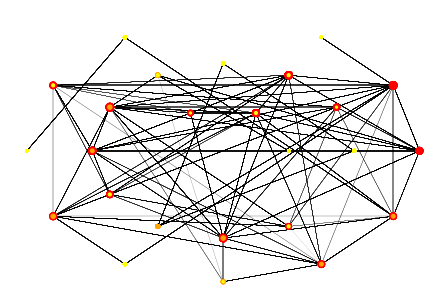

In [ ]:
## On trace l'animation en dessinant un nouveau graphe dès qu'une amitié se crée
## On print l'avancement de l'animation tous les 10 passages
## Le gif de l'animation se trouve ensuite dans vos téléchargements

fig = plt.figure()

N = len(fb)

def update(i):
    G = fb[i]
    D = nx.Graph()
    n = len(G[0])
    for j in range(n):
        D.add_node(j, weight = 5*poids_noeuds0(G)[j], color = 'yellow' if poids_noeuds0(G)[j]<(n/10) else 'orange' if poids_noeuds0(G)[j]<(n/7) else 'red' )
    D.add_edges_from(G[1])
    
    if i%10 == 0:
        print(100*i/N)
    
    shells = coquillage(len(G[0]),6)
    weights = list(nx.get_node_attributes(D,'weight').values())
    colors = list(nx.get_node_attributes(D,'color').values())
    nx.draw_shell(D, nlist = shells, node_size = weights, node_color = colors, width = 0.08)

ani = animation.FuncAnimation(fig, update, N, interval=1000, repeat=True)
ani.save('animation_facebook.gif', writer='pillow', fps=8)
plt.show()

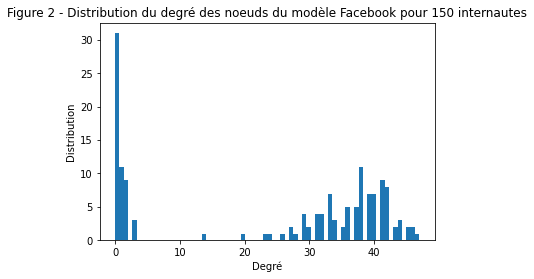

In [ ]:
## On regarde la distribution des degrés (obtenu pour 150 internautes)
plt.hist(poids_noeuds0(fb[-1]),  bins = 70)
plt.xlabel('Degré')
plt.ylabel('Distribution')
plt.title('Figure 2 - Distribution du degré des noeuds du modèle Facebook pour 150 internautes')
plt.show()

## 2 - Réseau de type Twitter

### On commence par utiliser un premier modèle avec seulement 30 internautes pour pouvoir tracer l'animation montrant l'évolution du réseau social.

In [ ]:
## Initialisation du premier modèle 
Nombre_internautes = 30
p0 = 1.5/Nombre_internautes ## On définit la probabilité de follow sur le graphe de départ

Internautes = [ k for k in range(Nombre_internautes) ] ## On associe un nombre à chaque internaute
Follows = [[-1 if i == j else (1 if rd.uniform(0,1)<p0  else 0) for i in range(Nombre_internautes) ] for j in range(Nombre_internautes) ] ## On crée la matrice d'adjacence du graphe de départ 

G = [ Internautes , Follows ] ## On crée le graphe de départ


Nombre_facteurs = 100 ## On définit des facteurs caractérisant les internautes

Scores = [ rd.randrange(100) for k in range(Nombre_facteurs) ] ## On associe un score d'importance à chaque facteur 
Facteurs = [ rd.sample( [k for k in range(Nombre_facteurs) ] , rd.randrange(Nombre_facteurs+1) ) for l in range(Nombre_internautes) ] ## On associe à chaque internaute certains facteurs


In [ ]:
def facteurs_communs(i,j): ## Calcul des facteurs communs aux internautes i et j
    return list(set(Facteurs[i]) & set(Facteurs[j]))

In [ ]:
def valeur(i,j):  ## Calcul de la valeur de la relation entre deux internautes à partir de l'importance de leurs facteurs communs
    score = 0
    for k in facteurs_communs(i,j):
        score += Scores[k]
    return score


In [ ]:
Valeurs = [ [ valeur(i,j) for i in range(Nombre_internautes) ] for j in range(Nombre_internautes) ] ## On calcule la valeur de chaque amitié

In [ ]:
def zero(G1): ## On cherche les non-follows qui peuvent encore le devenir
    Z = []
    for u in G1[0]:
        for v in G1[0]:
            if G1[1][u][v] == 0:
                Z.append((u,v))
    return Z

In [ ]:
def colonne(j,M): ## Recherche des followers de l'internaute j grâce à la matrice d'adjacence M
    l = []
    for i in range(len(M)):
        l.append(M[i][j])
    return l


In [ ]:
def poids_noeuds(G1): ## Calcul du degré de chaque noeud dans le graphe G
    return [ sum([k for k in colonne(j,G1[1]) if k>0]) for j in range(len(G1[0]))]


In [ ]:
def force(u,v,G,P): ## Calcul de la force de la relation de u vers v pour déterminer la probabilité de follow (P est poids_noeuds(G))
    return 5*P[v] + 0.1*Valeurs[u][v]

In [ ]:
def passage_animation(D0): ## Passage à l'étape suivante en regardant chaque possible follow
    G1 = D0[-1]
    D = []
    G0 = copy.deepcopy(G1)
    m = 0.1
    P = poids_noeuds(G0)
    Z = zero(G0)
    for (u,v) in Z:
        m = max(m, force(u,v,G0,P))
    for (u,v) in Z:
        r = rd.uniform(0,1)
        if r < 0.28*force(u,v,G0,P)/m :
            G0[1][u][v] = 1 
            D.append(copy.deepcopy(G0))
        if r > force(u,v,G0,P)/(0.9*m) :
            G0[1][u][v] = -1
    return D

In [ ]:
def evolution_animation(G0): ## Évolution du graphe G0 jusqu'à atteindre la condition d'arrêt
    L  = []
    D = [G0]
    while D != []:
        L += D
        D = passage_animation(D)
    return L


In [ ]:
def transfo(M): ## Transformation de la matrice d'adjacence M en la liste des follows
    L = []
    n = len(M)
    for u in range(n):
        for v in range(n):
            if M[u][v] == 1:
                L.append((u,v))
    return L

In [ ]:
def triple(L): ## On divise les degrés des internautes en trois groupes selon leur importance 
    l = copy.copy(L)
    l.sort()
    n = len(l)
    return [[l[i] for i in range(n//2)], [l[i] for i in range(n//2,n - n//5)], [l[i] for i in range(n - n//5,n)]]

In [ ]:
def dessin_sans_plot(G1): ## Fonction de dessin d'un graphe qui sera utile pour l'animation
    D = nx.Graph()
    P = poids_noeuds(G1)
    T = triple(P)
    for i in range(Nombre_internautes):
        D.add_node(i, weight = 5*P[i], color = 'yellow' if P[i] in T[0] else 'orange' if P[i] in T[1] else 'red' )
    D.add_edges_from(transfo(G1[1]))

    shells = coquillage(len(G1[0]),6)
    weights = list(nx.get_node_attributes(D,'weight').values())
    colors = list(nx.get_node_attributes(D,'color').values())
    
    nx.draw_shell(D, nlist = shells, node_size = weights, node_color = colors, width = 0.08)
    

In [ ]:
## Simulation de l'évolution du graphe de départ G 
twi = evolution_animation(G)

0.0
0.0
6.0606060606060606
12.121212121212121
18.181818181818183
24.242424242424242
30.303030303030305
36.36363636363637
42.42424242424242
48.484848484848484
54.54545454545455
60.60606060606061
66.66666666666667
72.72727272727273
78.78787878787878
84.84848484848484
90.9090909090909
96.96969696969697
0.0


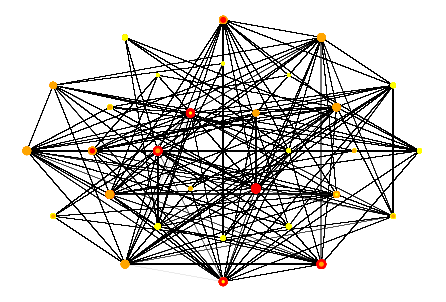

In [ ]:
## On trace l'animation en dessinant un nouveau graphe dès qu'un follow se crée
## On print l'avancement de l'animation tous les 10 passages
## Le gif de l'animation se trouve ensuite dans vos téléchargements

fig = plt.figure()

ntwi = len(twi)

def update(i):
    G = twi[i]
    if i%10 == 0:
        print(100*i/ntwi)
    dessin_sans_plot(G)

ani = animation.FuncAnimation(fig, update, frames=ntwi, interval=1000, repeat=True)
ani.save('animation_twitter.gif', writer = 'pillow', fps=8)
plt.show()

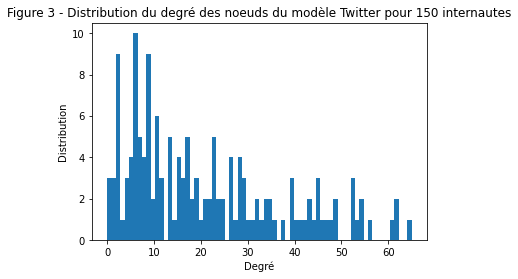

In [ ]:
## On regarde la distribution des degrés (obtenu pour 150 internautes)
plt.hist(poids_noeuds(twi[-1]),  bins = 70)
plt.xlabel('Degré')
plt.ylabel('Distribution')
plt.title('Figure 3 - Distribution du degré des noeuds du modèle Twitter pour 150 internautes')
plt.show()

### Pour le second modèle, on utilise plus d'internautes afin de pouvoir étudier les propriétés du réseau social obtenu.

In [ ]:
## Initialisation du  second modèle 
Nombre_internautes2 = 1767
p02 = 1.5/Nombre_internautes2

Internautes2 = [ k for k in range(Nombre_internautes2) ] ## On associe un nombre à chaque internaute
Follows2 = [[ -1 if i == j else (1 if rd.uniform(0,1)<p02  else 0) for i in range(Nombre_internautes2) ] for j in range(Nombre_internautes2) ] ## On crée la matrice d'adjacence du graphe de départ 

G2 = [ Internautes2 , Follows2 ] ## On crée le graphe de départ


Nombre_facteurs2 = 100 ## On utilise des facteurs définissant les internautes

Scores2 = [ rd.randrange(100) for k in range(Nombre_facteurs2) ] ## On associe un score d'importance à chaque facteur 
Facteurs2 = [ rd.sample( [k for k in range(Nombre_facteurs2) ] , rd.randrange(Nombre_facteurs2+1) ) for l in range(Nombre_internautes2) ] ## On associe à chaque internaute certains facteurs
Type2 = [np.random.exponential(0.1) for k in range(Nombre_internautes2)] ## On définit pour chaque internaute une probabilité de retweeter

In [ ]:
def facteurs_communs2(i,j): ## Calcul des facteurs communs aux internautes i et j
    return list(set(Facteurs2[i]) & set(Facteurs2[j]))


In [ ]:
def valeur2(i,j): ## Calcul de la valeur de la relation entre deux internautes à partir de l'importance de leurs facteurs communs
    return sum([ Scores2[k] for k in facteurs_communs2(i,j)])


In [ ]:
def force2(u,v,G,P): ## Calcul de la force de la relation de u vers v pour déterminer la probabilité de follow (P est poids_noeuds(G))
    return 5*P[v] + 0.0001*valeur2(u,v)

In [ ]:
def passage(G1): ## Passage à l'étape suivante en regardant chaque possible follow
    G0 = copy.deepcopy(G1)
    m = 0.1
    P = poids_noeuds(G0)
    Z = zero(G0)
    for (u,v) in Z:
        m = max(m, force2(u,v,G0,P))
    for (u,v) in Z:
        r = rd.uniform(0,1)
        f = force2(u,v,G0,P)/m
        if r < 0.015*f :
            G0[1][u][v] = 1 
        if r > f/1.01 :
            G0[1][u][v] = -1
    return G0

In [ ]:
def graphe_final(G): ## Évolution du graphe G0 jusqu'à atteindre la condition d'arrêt, on obtient alors le graphe final
    G1 = []
    G0 = copy.copy(G)
    while G1 != G0:
        G0 , G1 = passage(G0) , G0
    return G0

In [ ]:
## Calcul du graphe final à partir du graphe de départ G2
t1 = time.time()
fin = graphe_final(G2)
t2 = time.time()
t2 - t1

351.7176218032837

In [ ]:
## Méthode de code profiling très utile pour comprendre quelle partie du code consomme le plus de temps 
cProfile.run('graphe_final(G2)')

In [ ]:
def dessin(G1): ## Fonction de dessin du graphe G1
    D = nx.Graph()
    P = poids_noeuds(G1)
    T = triple(P)
    for i in range(Nombre_internautes2):
        D.add_node(i, weight = 0.001*P[i]**(2), color = 'yellow' if P[i] in T[0] else 'orange' if P[i] in T[1] else 'red' )
    for (u,v) in transfo(G1[1]):
        D.add_edge(u,v, couleur = 'yellow' if P[v] in T[0] else 'orange' if P[v] in T[1] else 'red' )
        
    shells = coquillage(len(G1[0]),6)
    weights = list(nx.get_node_attributes(D,'weight').values())
    colors = list(nx.get_node_attributes(D,'color').values())
    couleurs = list(nx.get_edge_attributes(D,'couleur').values())
    
    nx.draw_shell(D, nlist = shells, node_size = weights, node_color = colors, edge_color = couleurs, width = 0.009)
    plt.title('Figure 1 - Graphe final du modèle Twitter pour 1767 internautes')
    plt.show()

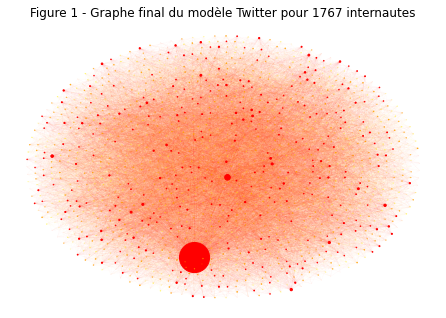

In [ ]:
## Dessin du graphe final
dessin(fin)

In [ ]:
print('La moyenne des degrés est de ' + str(np.mean(poids_noeuds(fin))))
print("L'écart-type des degrés est de " + str(np.std(poids_noeuds(fin))))

La moyenne des degrés est de 10.183927560837578
L'écart-type des degrés est de 25.065496812775656


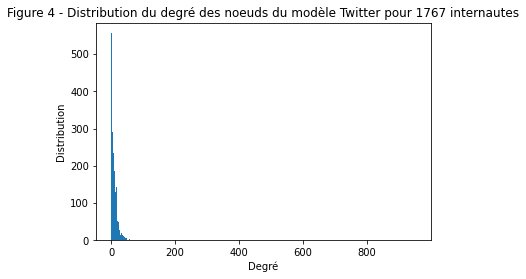

In [ ]:
## On regarde la distribution des degrés
plt.hist(poids_noeuds(fin),  bins = 300)
plt.xlabel('Degré')
plt.ylabel('Distribution')
plt.title('Figure 4 - Distribution du degré des noeuds du modèle Twitter pour 1767 internautes')
plt.show()

## 3 - Propagation de l'information

### On regarde d'abord les différentes communautés du graphe.

In [ ]:
## Définition d'un graphe (selon le vrai sens informatique pour python) à partir du graphe final
Dfin = nx.Graph()
Dfin.add_nodes_from(fin[0])
Dfin.add_edges_from(transfo(fin[1]))

In [ ]:
partition = com.best_partition(Dfin) ## Calcul des différentes communautés présentes dans le graphe final

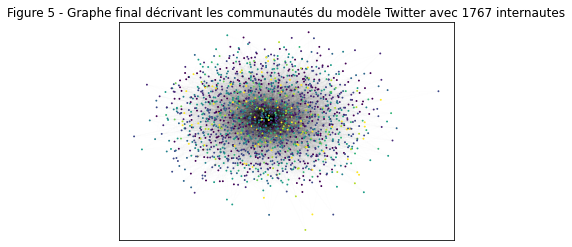

In [ ]:
## On trace le graphe final avec la couleur des noeuds selon leur communauté et des positions
pos = nx.spring_layout(Dfin) ## La position des noeuds est définie par l'algorithme de Fruchterman-Reingold
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(Dfin, pos, partition.keys(), node_size=0.8,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(Dfin, pos, alpha=0.5, width = 0.004)
plt.title('Figure 5 - Graphe final décrivant les communautés du modèle Twitter avec 1767 internautes')
plt.show()

### Puis, on simule le parcours de tweets.

In [ ]:
def un(l): ## On cherche les indices pour lesquelles la liste l vaut 1
    return [ i for i in range(len(l)) if l[i] == 1]
    

In [ ]:
def parcours(k,G1): ## Fonction qui simule le parcours d'un tweet de l'internaute k dans le graphe G1
    Proche = un(colonne(k,G1[1]))
    Touchés = [k] + Proche
    c = 0
    while Proche != []:
        Pro = copy.copy(Proche)
        Proche = []
        for l in Pro:
            r = rd.uniform(0,1)
            if r < Type2[l]:
                s = soustraction(un(colonne(l,G1[1])),Touchés)
                Proche += s
                Touchés += s 
        c+=1
    return len(Touchés), c, Touchés ## On obtient le nombre de personnes touchés, combien de personnes ont servi à atteindre la personne touchée la plus éloignée, et les personnes atteintes 
                

In [ ]:
## On fait tweeter 100 fois chaque internaute et on regarde le nombre de personnes atteintes
l = []
for k in range(Nombre_internautes2):
    o = []
    for i in range(100):
        o.append(parcours(k,fin)[0])
    l.append(o)

In [ ]:
m = [] 
s = []
for j in range(Nombre_internautes2):
    m.append(np.mean(l[j])) ## On obtient la moyenne du nombre de personnes atteintes pour chaque internaute sur ses 100 tweets
    s.append(np.std(l[j])) ## Et l'écart-type


Au vu des résultats suivants, il existe de grandes disparités entre les différents internautes et entre les différents tweets d'un même internaute.

In [ ]:
print('La moyenne du nombre de personnes atteintes sur tous les tweets est de ' + str(np.mean(m,dtype=np.float32)))
print("L'écart-type des moyennes du nombre de personnes atteintes est de " + str(np.std(m,dtype=np.float32))) ## Cela nous donne la variabilité entre les internautes
print('La moyenne des écart-types du nombre de personnes atteintes est de ' + str(np.mean(s,dtype=np.float32))) ## Cela nous donne la variabilité entre les tweets d'un même internaute

La moyenne du nombre de personnes atteintes sur tous les tweets est de 57.554916
L'écart-type des moyennes du nombre de personnes atteintes est de 70.92089
La moyenne des écart-types du nombre de personnes atteintes est de 86.36815


In [ ]:
degre = poids_noeuds(fin) ## On calcule les degrés des noeuds du graphe final

On observe une corrélation d'environ 75 % (cela varie entre chaque simlation) entre le nombre moyen de personnes atteintes par un tweet et le nombre de followers

In [ ]:
np.corrcoef(degre,m)

array([[1.        , 0.75427154],
       [0.75427154, 1.        ]])

In [ ]:
def proportion(partition): ## On regarde la proportion de chaque communauté dans le graphe 
    dict = {}
    for k in range(Nombre_internautes2):
        y = partition[k]
        if y in dict :
            dict[y] += 1/Nombre_internautes2
        else :
            dict[y] = 1/Nombre_internautes2
    return dict

In [ ]:
h = []
u = []
prop = proportion(partition)
for k in range(Nombre_internautes):
    x = 0
    y = partition[k]
    p = parcours(k,fin)[2]
    N = len(p)
    for j in p:
        if partition[j] == y:
            x +=1
    h.append(x/N) ## On obtient la proportion de personnes de sa communauté que l'internaute k a atteint
    u.append(prop[y]) ## On obtient la proportion de personnes de la communauté de l'internaute k

Alors qu'aléatoirement, une personne devrait toucher, parmi tous les gens qu'elle atteint, 12,9 % de de personnes de sa communauté, elle en atteint 33,8 % (Cela varie encore une fois selon la simulation). Des communautés se sont donc bien formées.

In [ ]:
np.mean(h) , np.mean(u)

(0.3384711167179541, 0.1291077155253731)

On n'obtient pas de corrélation entre la taille de la communauté et le nombres de personnes atteintes

In [ ]:
x = [ [] for k in range(len(prop))]
for i in range(Nombre_internautes2):
    x[partition[i]].append(m[i]) 

X = [ np.mean(x[k]) for k in range(len(prop))] ## On calcule combien de personnes sont touchées en moyenne par les internautes des différentes communautés

np.corrcoef(X,list(prop.values()))

array([[ 1.        , -0.54496699],
       [-0.54496699,  1.        ]])

## 4 - Récupération des données du compte Twitter de l'ENSAE

In [ ]:
import tweepy #librairie permettant d'accéder à l'API de Twitter
import pandas as pd

In [ ]:
# On rentre nos identifiants de l'API Twitter disponibles sur notre page développeur
consumer_key = "ucPBtjeiK26Zf9cBdIKwsfo7k"
consumer_secret = "cpLvFYc0k3DvpND1gfMwWPMuYAdaTip6AHyOE0NfEkkp8ZGxGS"
access_token = "1391391874104111104-NV0BfVloqmBuouWOtOaI9F7QbSvRzm"
access_token_secret = "81MOBthX46SuLGQR0faUj0ijP1lpBW5blUiZ6a64DlX31"

In [ ]:
# On s'identifie auprès de tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True) #on met ces paramètres sur True afin de ne pas casser la connexion avec l'API lorsque la limite de requête a été atteinte

In [ ]:
# On récupère l'ID Twitter du compte de l'ENSAE
ensae = api.get_user(screen_name = "ENSAEparis")
ensae.id

919247378196107266

In [ ]:
#Cette partie du code destinée à récupérer l'ensemble des followers du compte Twitter de l'ENSAE est détaillé dans le rapport (B Point de design du code)

user_list = ["919247378196107266"]
follower_list = []
for user in user_list:
    followers = []
    try:
        for page in tweepy.Cursor(api.followers_ids, user_id=user).pages():
            followers.extend(page)
            print(len(followers))
    except tweepy.TweepError:
        print("error")
        continue
    follower_list.append(followers)

1771


In [ ]:
#On met la liste des followers dans un dataframe
df = pd.DataFrame(columns=['source','target']) #Création d'un dataframe vide
df['target'] = follower_list[0] #Définir la liste des followers comme colonne target
df['source'] = 919247378196107266 #Définir l'ID de l'ENSAE comme la source
df.to_csv("followers_ensae.csv")

⚠️ L'ensemble des données récupérées ici et plus loin dans le code, sont exportées au format csv afin que vous puissiez les utiliser directement sans avoir à lancer tout le code.

Les fichiers *followers_ensae* et *networkOfFollowers* (utilisé plus loin) sont disponibles dans le répertoir GitHub : https://github.com/AV8-hub/chicken837

In [ ]:
G = nx.from_pandas_edgelist(df, 'source', 'target') #Création d'un graphe à partir de df
pos = nx.spring_layout(G) 

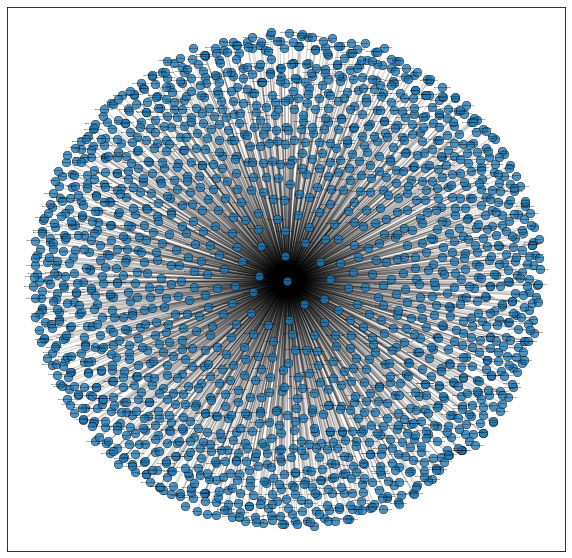

In [ ]:
#On trace ensuite ce réseau "simple" en utlisant matplotlib
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(G, pos,node_size=75,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(G, pos, font_size=1.5)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.2)
plt.show()

Notre objectif étant cependant de récupérer les followers de l'ensemble des followers de l'ENSAE. On effectue donc une boucle sur la liste des followers de l'ENSAE pour obtenir leurs followers et ainsi ajouter ces liens dans un dataframe.

⚠️ Le code suivant est très long à tourner pour des raisons explicitées dans le rapport (limite de requêtes par l'API Twitter à 15 requêtes / 15mins). 

Ne le lancez pas !

In [ ]:
user_list = list(df['target']) #On utlise la liste des followers obtenues précedemment
for userID in user_list:
    print(userID)
    followers = []
    follower_list = []

    # On récupère l'utilisateur
    user = api.get_user(userID)

    # On récupère le nb de followers
    followers_count = user.followers_count

    try:
        for page in tweepy.Cursor(api.followers_ids, user_id=userID).pages():
            followers.extend(page)
            print(len(followers))
            if followers_count >= 5000: #on se limite aux 5000 premiers followers
                break
    except tweepy.TweepError:
        print("error")
        continue
    follower_list.append(followers)
    temp = pd.DataFrame(columns=['source', 'target'])
    temp['target'] = follower_list[0]
    temp['source'] = userID
    df = df.append(temp)
    df.to_csv("networkOfFollowers.csv")

Il vous suffit de lancer la cellule suivante pour récupérer les données déjà sauvegardées au format csv 

In [ ]:
df = pd.read_csv("followers_ensae.csv") 
df2 = pd.read_csv("networkOfFollowers.csv") 

In [ ]:
#On récupère la liste des followers de l'ensae et celle des followers des followers de l'ensae
liste_followers_ensae = df['target'].tolist()
liste_followers_followers_ensae = df2['target'].tolist()

In [ ]:
#On veut obtenir un réseau social primaire, on va donc se limiter à regarder les relations entre les followers de l'ENSAE
#On récupère donc la liste des lignes du dataframe dont target n'est pas un follower de l'ensae
L2=[]
for i in range(len(df2)):
    if df2['target'][i] not in liste_follower_ensae:
        L2.append(i)

In [ ]:
df3 = copy.copy(df2)
df3.drop(L2,0,inplace=True) #Suppression des lignes du dataframe dont target n'est pas un follower de l'ensae

In [ ]:
df3.drop(df3.loc[df3['source'] == 919247378196107266].index, inplace=True) #suppression des lignes du dataframe dont la source est l'id de l'ensae

In [ ]:
del df3['Unnamed: 0'] #suppresion de la colonne unnamed

In [ ]:
# On convertit le dataframe en une liste de tuple
records = df3.to_records(index=False)
result = list(records)

In [ ]:
#on a une list de tuple de la forme [(source = v, target = u),...] avec target qui suit la source
# On inverse pour avoir u suit v dans le tuple
Li= []
for v,u in result:
    Li.append((u,v))

Nous nous sommes rendus compte qu'entre le moment où nous avons récupéré la liste des followers de l'ENSAE et le moment oùu nous avons récupéré la liste des followers des followers de l'ENSAE, un compte avait arrêté de follow l'ENSAE (ID = 1008747185683533827) ce qui causait une erreur lors de la création de la matrice d'adjacence. 
On récupère alors les indices des tuples de Li où ce follower intervient et on supprime les tuples associés.

In [ ]:
#suppression du follower qui a arrêté de follow l'ensae
for k in range(len(Li)):
    u,v = Li[k]
    if u == 1008747185683533827 or v == 1008747185683533827:
        print(k)

10004
10005


In [ ]:
# On utilise la méthode pop pour vérifier qu'on supprime les bons éléments
Li.pop(10004), Li.pop(10004) #on met deux fois 10004 car lors de la première suppression l'ensemble la liste est décalé vers la "gauche"

((63175888.0, 1008747185683533827), (198500394.0, 1008747185683533827))

In [ ]:
#Creation de la matrice d'adjacence
Lid = [[0 for k in range(len(liste_follower_ensae))] for l in range(len(liste_follower_ensae))]
for u,v in Li:
    Lid[liste_follower_ensae.index(u)][liste_follower_ensae.index(v)] = 1

fin2 = [liste_follower_ensae, Lid]

In [ ]:
print('La moyenne est de ' + str(np.mean(poids_noeuds(fin2))))
print("L'écart-type est de " + str(np.std(poids_noeuds(fin2))))

La moyenne est de 10.092246745897
L'écart-type est de 27.34621520449263


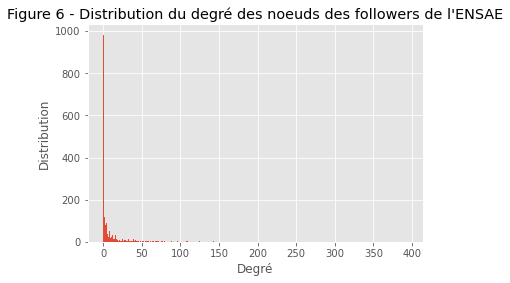

In [ ]:
## On regarde la distribution des degrés
plt.hist(poids_noeuds(fin2),  bins = 300)
plt.xlabel('Degré')
plt.ylabel('Distribution')
plt.title("Figure 6 - Distribution du degré des noeuds des followers de l'ENSAE")
plt.show()

In [ ]:
Type_ensae = [np.random.exponential(0.1) for k in range(len(liste_follower_ensae))] ## On définit pour chaque internaute une probabilité de retweeter

In [ ]:
Type2 = Type_ensae
## On fait tweeter 100 fois chaque internaute et on regarde le nombre de personnes atteintes
l2 = []
for k in range(len(liste_follower_ensae)):
    o2 = []
    for i in range(100):
        o2.append(parcours(k,fin2)[0])
    l2.append(o2)

In [ ]:
m2 = [] 
s2 = []
for j in range(len(liste_follower_ensae)):
    m2.append(np.mean(l2[j])) ## On obtient la moyenne du nombre de personnes atteintes pour chaque internaute sur ses 100 tweets
    s2.append(np.std(l2[j])) ## Et l'écart-type

In [ ]:
print('La moyenne du nombre de personnes atteintes sur tous les tweets est de ' + str(np.mean(m2,dtype=np.float32)))
print("L'écart-type des moyennes du nombre de personnes atteintes est de " + str(np.std(m2,dtype=np.float32))) ## Cela nous donne la variabilité entre les internautes
print('La moyenne des écart-types du nombre de personnes atteintes est de ' + str(np.mean(s2,dtype=np.float32))) ## Cela nous donne la variabilité entre les tweets d'un même internaute

La moyenne du nombre de personnes atteintes sur tous les tweets est de 122.80575
L'écart-type des moyennes du nombre de personnes atteintes est de 181.73358
La moyenne des écart-types du nombre de personnes atteintes est de 116.5485
